In [2]:
# steps: add eval generator, 
# add batches, start to get score ? 
# add refined losses


### Issues: Tensorflow can't find GPU; possible solutions: retry old install.. 

In [1]:
from __future__ import division

import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Concatenate
#from keras.utils.visualize_util import plot"
from keras.utils import np_utils

from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
#keras.backend.image_dim_ordering='th'


from keras import backend as K
import theano
theano.config.optimizer='fast_compile'
#theano.config.exception_verbosity='high'
#theano.config.compute_test_value = 'warn'

Using Theano backend.


#### Step 1: Import Data  (with image path & target array) 

In [2]:
keras.__version__

'2.0.6'

####  Start with blue layer

In [2]:
train_index=pd.read_csv('final_csv.csv')

In [3]:
train_index=train_index.set_index('path')
train_index.head()

,image,image_name,clothes_type,variation_type,landmark_visibility_1,landmark_location_x_1,landmark_location_y_1,landmark_visibility_2,landmark_location_x_2,landmark_location_y_2,...,landmark_location_y_3_sld,landmark_location_x_4_sld,landmark_location_y_4_sld,landmark_location_x_5_sld,landmark_location_y_5_sld,landmark_location_x_6_sld,landmark_location_y_6_sld,lms,evaluation_status,file
path,,,,,,,,,,,,,,,,,,,,,
train/img_00000001.jpg,img_00000001.jpg,img/img_00000001.jpg,1,1,0,144,156,0,221,159,...,0.424361,0.490119,0.465483,0.225873,0.792829,0.469636,0.801193,"[0.2993492407809111, 0.3681710213776722, 0.444...",train,train/img_00000001.jpg
val/img_00000002.jpg,img_00000002.jpg,img/img_00000002.jpg,1,3,1,111,104,0,153,105,...,0.282908,0.353755,0.317554,0.170431,0.354582,0.267206,0.375746,"[0.227765726681128, 0.24465558194774348, 0.298...",val,val/img_00000002.jpg
train/img_00000003.jpg,img_00000003.jpg,img/img_00000003.jpg,1,1,1,112,113,0,172,117,...,0.330059,0.411067,0.339250,0.205339,0.531873,0.368421,0.502982,"[0.2299349240780911, 0.2660332541567696, 0.339...",train,train/img_00000003.jpg
train/img_00000004.jpg,img_00000004.jpg,img/img_00000004.jpg,1,2,1,76,74,1,108,69,...,0.220039,0.276680,0.193294,0.133470,0.326693,0.244939,0.320080,"[0.15184381778741865, 0.17339667458432304, 0.2...",train,train/img_00000004.jpg
train/img_00000005.jpg,img_00000005.jpg,img/img_00000005.jpg,1,1,1,217,139,1,290,156,...,0.434185,0.644269,0.489152,0.373717,0.605578,0.615385,0.604374,"[0.45770065075921906, 0.32779097387173395, 0.5...",train,train/img_00000005.jpg


In [4]:
# normalizing landmark features
def landmarks(df):
    my_list=[df.landmark_location_x_1_sld,df.landmark_location_y_1_sld,df.landmark_location_x_2_sld,df.landmark_location_y_2_sld,
             df.landmark_location_x_3_sld,df.landmark_location_y_3_sld,df.landmark_location_x_4_sld,df.landmark_location_y_4_sld,
             df.landmark_location_x_5_sld,df.landmark_location_y_5_sld,df.landmark_location_x_6_sld,df.landmark_location_y_6_sld]
    return my_list

train_index['lms']=train_index.apply(landmarks,axis=1)


Y1=train_index[['landmark_visibility_1']]
Y2=train_index[['landmark_visibility_2']]
Y3=train_index[['landmark_visibility_3']]
Y4=train_index[['landmark_visibility_4']]
Y5=train_index[['landmark_visibility_5']]
Y6=train_index[['landmark_visibility_6']]

In [8]:
Y1.head()

,landmark_visibility_1
path,
train/img_00000001.jpg,0
val/img_00000002.jpg,1
train/img_00000003.jpg,1
train/img_00000004.jpg,1
train/img_00000005.jpg,1


#### Start with Blue layer.. 
Leveraging pretrained model ..  

In [5]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense

vgg16 = VGG16(weights='imagenet')



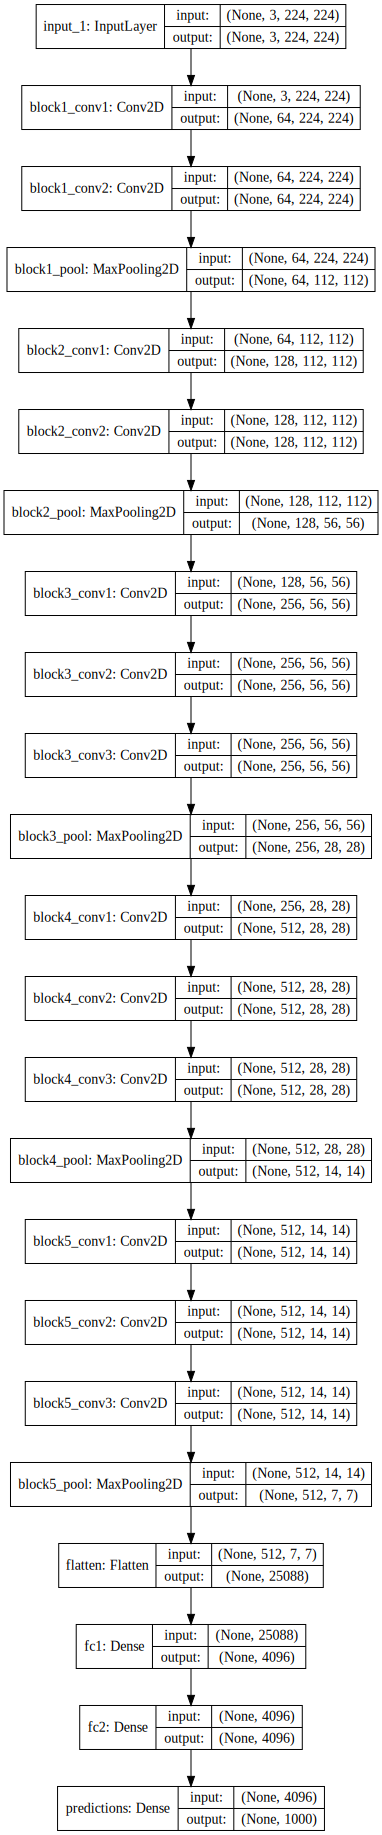

In [6]:
SVG(model_to_dot(vgg16,show_shapes=True).create(prog='dot',format='svg'))

###  Let's try to leverage transfer learning.. 
 will freeze all convolultional layer, but will try to refine dense layer
 
 ## OPEN:
 
Compare : conv5 as fresh vs frozen?

In [7]:
# Freeze all layers for now except last convolutional block  
for layer in vgg16.layers[:15]:
    layer.trainable = False

In [8]:
# grab output directly after last conv layer
convs = vgg16.get_layer('flatten').output


In [9]:

#let's create new layers
new = Dense(4096, activation='relu', name='fc6_pose')(convs)
new = Dense(4096, activation='relu', name='fc7_pose')(new)

# predict locations

# output : 2 visibility probabilities
vis1 = Dense(2, activation='softmax', name='visibility1')(new)
vis2 = Dense(2, activation='softmax', name='visibility2')(new)
vis3 = Dense(2, activation='softmax', name='visibility3')(new)
vis4 = Dense(2, activation='softmax', name='visibility4')(new)
vis5 = Dense(2, activation='softmax', name='visibility5')(new)
vis6 = Dense(2, activation='softmax', name='visibility6')(new)

# landmark outputs
lm=Dense(12,activation='linear',name='landmarks')(new)

#blue_out=[vis1, vis2, vis3, vis4,vis5, vis6, lm]


####  Now add in Green layer:
- inputs are feature maps (conv4 layer) & estimated landmarks 
a) For each landmark location (we 1st determine visibility v). The 
responses of invisible landmarks are gated to zero
b) We perform max-pooling inside the region around landmarks to obatin local feature maps
c) back-prop of landmark pooling layer is similar to the ROI pooling layer introduced in [8],
however instead of treating pooled regions independently, the landmark pooling layer captures
interactions between clothing landmarks by concatentating local features

In [58]:
type(lm)

theano.tensor.var.TensorVariable

In [10]:
conv4=vgg16.get_layer('block4_pool').input

In [ ]:
# Notes: keep everything within Keras tensors (try not to use np.arrays!)

In [11]:
# function to change lm (6x2)~ (x,y)  to (6x4) ~(x,y,w,h)  where there are 6 landmarks
def get_rois(lm):
    
    pred_lm=K.reshape(lm,(6,2))
    # append w,h to lm array 
    
    x=K.ones((6,2))*3
    
    pred_lm=K.concatenate((pred_lm,x),axis=1)
    
    pred_lm=K.reshape(pred_lm,(1,6,4))
    
    
    return pred_lm


    
rois=get_rois(lm) 



### This is our input for the 2nd layer

Open: need to revisit.  ROI needs to go away if item is occluded, 
also should find a good way to tailor ROI sizes (w,h)

In [13]:
# develop roi_input with roi_pool.py

from roi_pool import RoiPoolingConv

# input : list of two 4D tensors [X_img,X_roi]  ~ we really want to feed conv4 in lieu of img

# X_roi  : list of rois, with ordering (x,y,w,h)

roi=RoiPoolingConv(2,6)([conv4,rois])

####  Green Layer

In [14]:
# continue with green layer, (aka local)

# define as an input tensor!, Input layers to a `Model` must be `InputLayer` objects.
roi=Input(tensor=roi)


#also need to get main image input!
img=vgg16.get_layer('block1_conv1').input
input_blue=Input(tensor=img)

fc6_local=Flatten()(roi)
fc6_local = Dense(1024, activation='relu', name='fc6_local')(fc6_local)


outputs= [vis1, vis2, vis3, vis4,vis5, vis6, lm,fc6_local]
#outputs=[ fc6_local]
                                        

#model=Model(inputs=[input_blue,roi],outputs=outputs)


#### Red Layer

Notes:
- outputs of the branches in red and green are concatenated together as in “fc7 fusion”
- input is just conv4


In [16]:
input_red= vgg16.get_layer('block4_pool').input

input_red=Input(tensor=input_red)

# Develop last convolutional block
red = MaxPooling2D((2,2), strides=(2,2))(input_red)
red = ZeroPadding2D((1,1))(red)
red = Convolution2D(512, (3, 3), activation='relu')(red)
red = ZeroPadding2D((1,1))(red)
red = Convolution2D(512, (3, 3), activation='relu')(red)
red = ZeroPadding2D((1,1))(red)
red = Convolution2D(512, (3, 3), activation='relu')(red)
red =MaxPooling2D((2,2), strides=(2,2))(red)

red=Flatten()(red)
fc6_global = Dense(4096, activation='relu', name='fc6_global')(red)

fc7_fusion = keras.layers.concatenate([fc6_local,fc6_global])

#fc7_fusion=Dense(5120, activation='relu', name='fc7_fusion')(fc7_fusion)


In [17]:
atts=Dense(1000,activation='softmax',name='attributes')(fc7_fusion)
cat=Dense(50,activation='softmax',name='categories')(fc7_fusion)



In [19]:
outputs= [vis1, vis2, vis3, vis4,vis5, vis6, lm,fc6_local,atts,cat]

model=Model(inputs=[input_blue,roi,input_red],outputs=outputs)

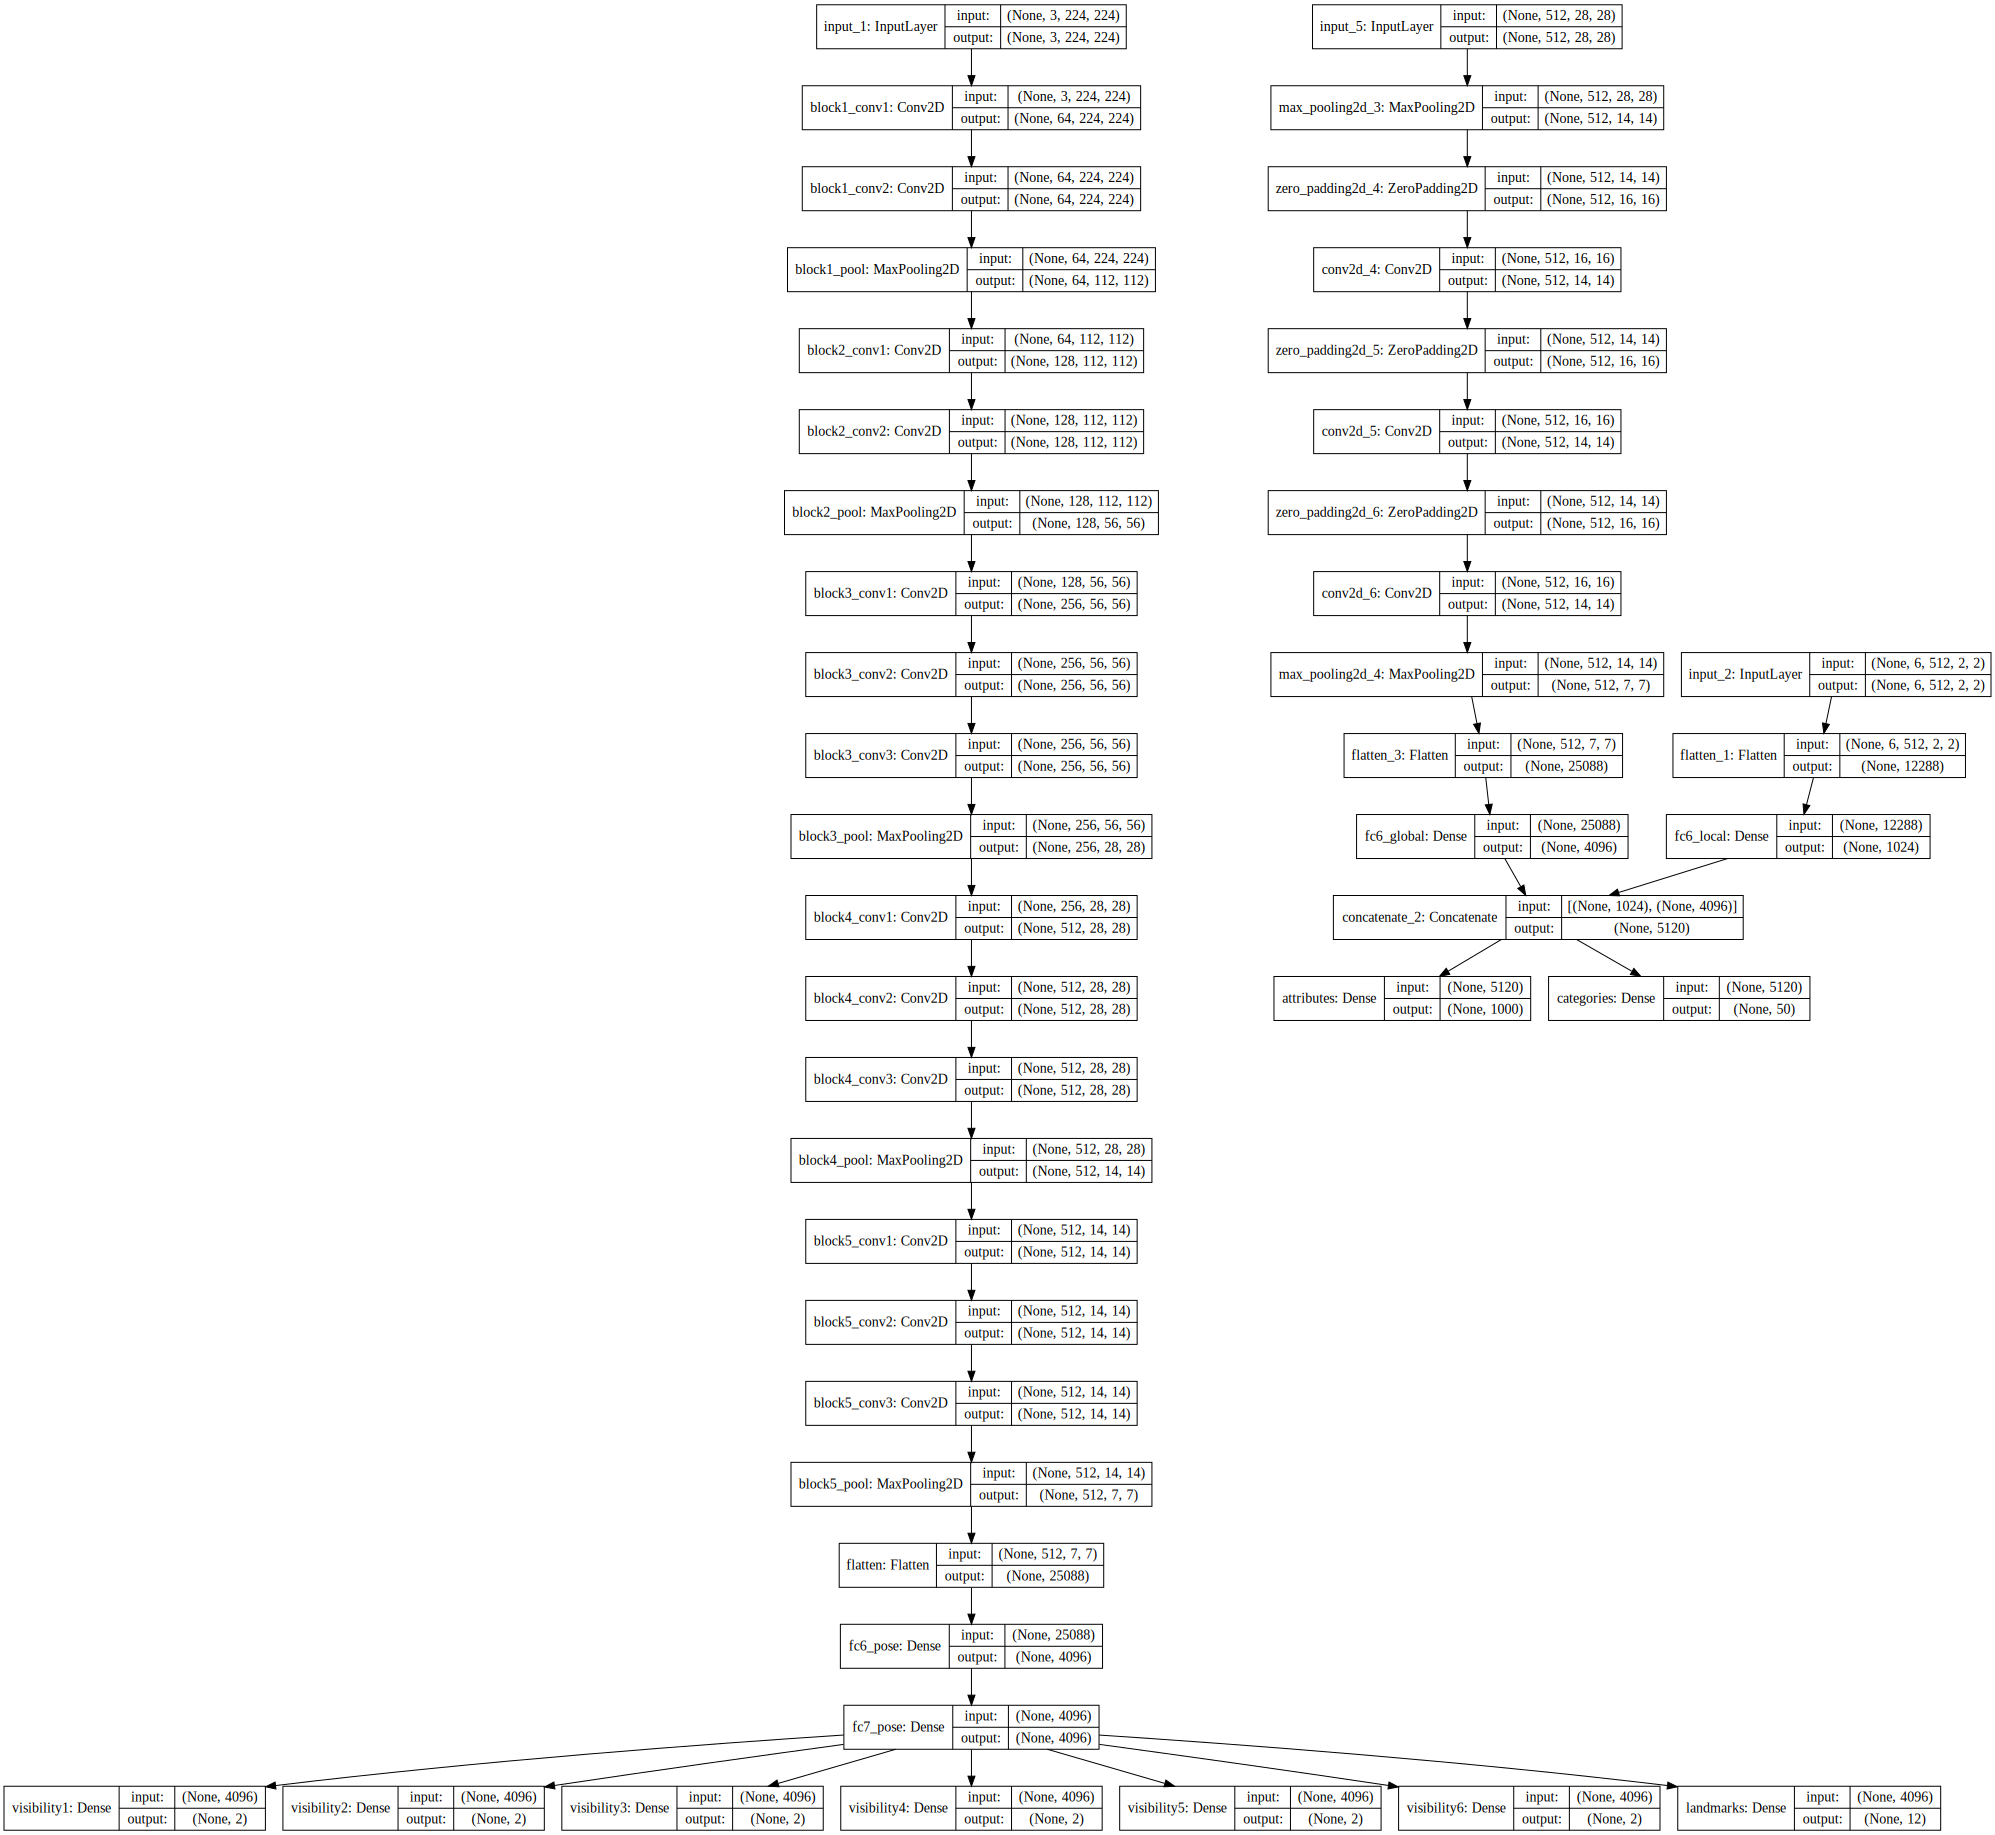

In [20]:
SVG(model_to_dot(model,show_shapes=True).create(prog='dot',format='svg'))

####  Get labels for red layer

In [25]:
list_attri=pd.read_csv('/Users/julialintern/Downloads/list_attr_img.txt',header=1,delimiter='\t', error_bad_lines=False)

In [36]:
list_attri.columns

Index(['image_name  attribute_labels'], dtype='object')

In [44]:
#list_attri['image_name  attribute_labels'][0]

In [47]:
atts={}
for i in range(len(list_attri)):
    item=list_attri['image_name  attribute_labels'][i]
    i=item.split()
    atts[i[0]]=i[1:]
    
    

In [ ]:
list[atts.items()][0]

In [ ]:
att_labels=pd.DataFrame.from_dict(atts,orient='index')

In [ ]:
att_labels.head()

#### predictions:
- landmarks, landmark visibility, clothing category (softmax) (fine-grained),
- cross entropy loss for attribute prediction, & triplet loss for metric 
- learning of pairwise clothes images


In [ ]:
Lattributes =    wpos · aj log p(aj |xj ) +wneg ·(1−aj)log(1−p(aj|xj)) ,
# note, this approach forces a penalaty on the incorrect classes as well, 
#  not sure how to determine weights ?! 

In [ ]:
Ltriplet = max{0,m+d(xj,x+j )−d(xj,x−j )},


Fashion Net is optimized by combining the above loss functions. 
Here we discuss the iterative training strate. that repeats the following 2 steps:
1) First: treat the blue branch as the main task, and the 2nd branches 
as aux tasks.  (Lviz & Llandmark with large weights), others have small weights. 

2) Second: predict clothing attributes & categories as well as learn 
pairwise relations between clothing images 

Repeat these 2 steps iteratively.. 

### Important note


It's important to remember that the node connectivity is actually added to the layer instance itself, this sadly means you can't re-use the layer in multiple graphs with totally different connectivity.
You will have to re-instantiate (redefine) a new identical, unconnected, layer.


(wrong)
conv4=model.get_layer('block4_conv3').output

will have to redefine conv4


In [396]:
# how to treat output as input ? 


#conv4=model.get_layer('block4_pool')

conv4=vgg16.get_layer('block4_pool').input


#input_green = keras.layers.concatenate([conv4, lm])
green=MaxPooling2D(pool_size=(2,2), name='pool5_local')(conv4)
fc6_local = Dense(4096, activation='relu', name='fc6_local')(green)


outputs=[fc6_local]
model=Model(inputs=conv4,outputs=outputs)

/usr/local/lib/python2.7/site-packages/keras/engine/topology.py:1500: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "model_33" was not an Input tensor, it was generated by layer block4_conv3.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: None
  str(x.name))


AttributeError: 'Conv2D' object has no attribute 'is_placeholder'

In [324]:


#model = Model(input=vgg16.input, output=blue_out)
#model.summary()

AttributeError: 'NoneType' object has no attribute 'inbound_nodes'

#### Blue Branch Losses
- Regression loss for landmark localization & softmax for visibility
 - a) Modified L2 regression loss is ussed to localize landmarks
   dot(vj,(lj_hat-lj)**2

In [14]:
from keras.preprocessing import image
import keras.backend as K

train_gen= keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

In [ ]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/home/ubuntu/upper/make_test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='sparse')


#### Get All the Labels, 
Feed into model as numpy arrays

In [ ]:

## Training & Test : get binary labels for visibility 

def get_labels(labels,generator):
    # ex: all filenames of train_generator
    get_list=generator.filenames
    labs=labels.loc[get_list]
    labs=labs.as_matrix()
    labs=np_utils.to_categorical(labs)
    return labs
    

# get all labels for occlusion
train_lab_1=get_labels(Y1,train_generator)
test_lab_1=get_labels(Y1,test_generator)

train_lab_2=get_labels(Y2,train_generator)
test_lab_2=get_labels(Y2,test_generator)

train_lab_3=get_labels(Y3,train_generator)
test_lab_3=get_labels(Y3,test_generator)

train_lab_4=get_labels(Y4,train_generator)
test_lab_4=get_labels(Y4,test_generator)

train_lab_5=get_labels(Y5,train_generator)
test_lab_5=get_labels(Y5,test_generator)

train_lab_6=get_labels(Y6,train_generator)
test_lab_6=get_labels(Y6,test_generator)


In [ ]:
## get landmark labels 

landmarks=train_index[['lms']]

def get_labels_lm(labels,generator):
    # ex: all filenames of train_generator
    get_list=generator.filenames
    labs=labels.loc[get_list]
    return np.array(list(labs))

lm_train_labels=get_labels_lm(train_index.lms,train_generator)
lm_test_labels=get_labels_lm(train_index.lms,test_generator)
#lm_train_labels[:5]

In [ ]:
5228/16

In [ ]:
# now we have 21488
def train_flow_from_directory(flow_from_directory_gen, list_of_values1,list_of_values2,list_of_values3,list_of_values4,\
                              list_of_values5,list_of_values6,list_of_values7):
    # create infinite loop for labels, 
        
    for i,x in enumerate(flow_from_directory_gen):
        i = i%1343
        # control for half of a batch
        length=len(x[0])
        yield(x[0],[list_of_values1[i*16:i*16+length],list_of_values2[i*16:i*16+length],\
                    list_of_values3[i*16:i*16+length],list_of_values4[i*16:i*16+length],\
                    list_of_values5[i*16:i*16+length],list_of_values6[i*16:i*16+length],
                   list_of_values7[i*16:i*16+length]])

In [ ]:
# now we have 5228
def test_flow_from_directory(flow_from_directory_gen, list_of_values1,list_of_values2,list_of_values3,list_of_values4,
                             list_of_values5,list_of_values6,list_of_values7):
    # create infinite loop for labels, 
        
    for i,x in enumerate(flow_from_directory_gen):
        i = i%326
        # control for half of a batch
        length=len(x[0])
        # outputs need to be in a list! 
        yield(x[0],[list_of_values1[i*16:i*16+length],list_of_values2[i*16:i*16+length],list_of_values3[i*16:i*16+length]\
                    ,list_of_values4[i*16:i*16+length],list_of_values5[i*16:i*16+length],list_of_values6[i*16:i*16+length],
                   list_of_values7[i*16:i*16+length]])
            
#regression_flow_from_directory(train_generator, list_in_order)

##### See Backward Pass & Losses
backward pass: back-propagates the errors of four kinds of loss functions iteratively, 
A modified L2 regression loss is used to localize landmarks 
L = (summation)||vj*(actual-predicted)||^2
vj~ vector of predicted landmarks

In landmark visibility state, "0" represents visible;

In [ ]:
# sweet: Keras will automatically read in predictions; 


def custom_objective(y_true, y_pred):
    '''tailored cost function'''
    
    #get landmarks

    pred_lm=y_pred[6]
    true_lm=y_true[6]
    
    pred_lm=K.reshape(pred_lm,(6,2))
    true_lm=K.reshape(true_lm,(6,2))
    
    
    
    # get visibility binaries
    true_viz=y_true[:6]
    
    # predict if visible or not, if not visible, set landmark loss to zero
    wins=K.argmax(true_viz,axis=1)
    
    #shapes : wins: (1,6), pred_lm: 6,2
    loss=K.mean(K.square(K.dot(wins,(pred_lm-true_lm))))  # 
    
    
    
    return loss

In [ ]:
def custom_metric(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred))



In [ ]:
from keras import backend as K

def single_class_accuracy(interesting_class_id):
    def fn(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_preds = K.argmax(y_pred, axis=-1)
        # Replace class_id_preds with class_id_true for recall here
        accuracy_mask = K.cast(K.equal(class_id_preds, interesting_class_id), 'int32')
        class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
        class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
        return class_acc
    return fn

In [ ]:
# metrics : used to judge the performance (but classifier only makes changes based on )

from keras.optimizers import SGD, Adam

#losses=['sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy',custom_objective]

losses=['binary_crossentropy','binary_crossentropy','binary_crossentropy','binary_crossentropy','binary_crossentropy',
'binary_crossentropy', custom_objective]
my_metrics=[single_class_accuracy(0)]
#my_metrics=['accuracy','accuracy','accuracy','accuracy',custom_metric]


#sgd = SGD( lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True,clipnorm=1.0)
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# try adding clipnorm, and clipvalue -- because gradients are going thru da roof

model.compile(loss=losses,optimizer=adam,metrics=my_metrics)

#metrics=my_metrics

In [ ]:
keras.__version__

In [ ]:
## 8907, 1735

filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5'
mcp=keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

cb2=keras.callbacks.RemoteMonitor(root='http://localhost:9001')
callback=[mcp,cb2]
test=model.fit_generator(train_flow_from_directory(train_generator, train_lab_1,train_lab_2,train_lab_3,train_lab_4,train_lab_5,train_lab_6, lm_train_labels),\
                         validation_data=test_flow_from_directory(test_generator, test_lab_1,test_lab_2,test_lab_3,test_lab_4,test_lab_5,test_lab_6,\
                                                                  lm_test_labels),
                         nb_epoch=20,samples_per_epoch=20000, nb_val_samples=5000,callbacks=callback)


In [ ]:
# We have subset on clothes_type: upper (collars, and sleeves)

test=train_index[(train_index.landmark_visibility_3==0)&(train_index.landmark_visibility_4==0)]
test.head(3)

In [ ]:
from scipy import ndimage
base='/home/icarus/mount_data/'

img=ndimage.imread(base+'img/Sheer_Pleated-Front_Blouse/img_00000002.jpg')
plt.imshow(img)
plt.show()

In [ ]:
## ISSUES: 

#  keras returning loss ~ nan , 

# solved it by changing the floatx value in ~/.keras/keras.json from float32 to float64. (tested on GPU)
# running slower, but now getting Loss values returned


In [ ]:
# scraps:

# extract region of interest from the Conv. 4 layers: 

# pseudo conv layer
test=np.ones([512,28,28])


test=test.reshape([28,28,512])



pred_lm=[.1,.2,.3,.4,.5,.6,.7,.8,.1,.2,.3,.4]
pred_lm=np.reshape(pred_lm,(6,2))

# scale lm : to 0- 28
scaled_lm=np.multiply(pred_lm,28).astype(int)

scaled_lm2=np.add(scaled_lm,3)
print (scaled_lm)[0]
print (scaled_lm2)[0]


#create ROI, x1:x2,y1:y2
subs=np.array([np.array(test[scaled_lm[i][0]:scaled_lm[i][0]+3, \
                             scaled_lm[i][1]:scaled_lm[i][1]+3]).reshape(512,3,3)\
               for i in range(6)])

subs[2].shape

In [191]:
test=np.ones([512,28,28])


test=test.reshape([28,28,512])



pred_lm=[.1,.2,.3,.4,.5,.6,.7,.8,.1,.2,.3,.4]
pred_lm=np.reshape(pred_lm,(6,2))

# scale lm : to 0- 28
scaled_lm=np.dot(pred_lm,28).astype(int)
scaled_lm

array([[ 2,  5],
       [ 8, 11],
       [14, 16],
       [19, 22],
       [ 2,  5],
       [ 8, 11]])

In [ ]:
# for ROI test

test=np.random.randint(1,size=(512,28,28))

rois=np.array([test[:,1:2,3:4]
               for i in range(6)])
rois.shape

In [410]:
## testing with functional api

from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

In [411]:
main_input = Input(shape=(100,), dtype='int32', name='main_input')
x = Embedding(output_dim=512, input_dim=10000, input_length=100)(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(x)

In [412]:
auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)